In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data 
import math
import torch.nn.functional as F

from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
from torch.distributions.beta import Beta

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

## Generating the data and preparing the dataloader

In [2]:
n_train, n_test = 2000, 1000
train_data, train_labels = make_moons(n_samples=n_train, noise=0.07)
test_data, test_labels = make_moons(n_samples=n_test, noise=0.07)

train_data = np.float32(train_data)
test_data = np.float32(test_data)

train_loader = data.DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=256, shuffle=True)## Visualizing the data

## Visualizing the data

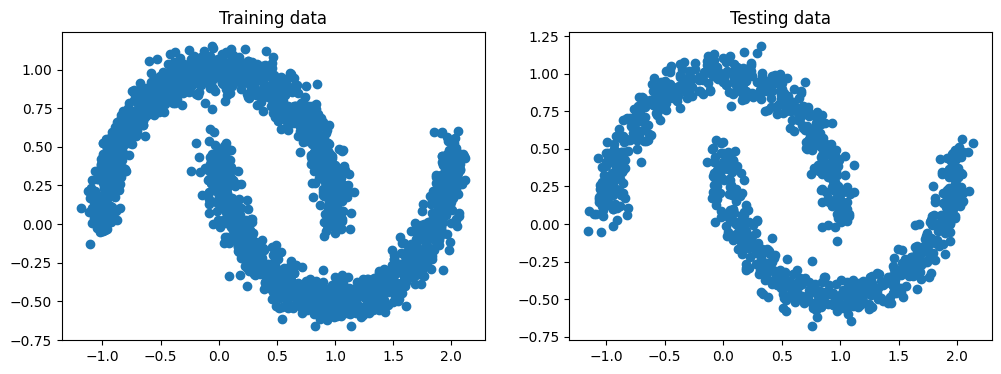

In [3]:
_, axes = plt.subplots(1,2,figsize=(12,4))
x,y = train_loader.dataset[:,0], train_loader.dataset[:,1]
_ = axes[0].scatter(x,y)
_ = axes[0].set_title('Training data')

x,y = test_loader.dataset[:,0], test_loader.dataset[:,1]
_ = axes[1].scatter(x,y)
_ = axes[1].set_title('Testing data')

## MAF model

In [4]:
def create_masks(input_size, hidden_size, n_hidden,  input_degrees=None):
    degrees = []

    degrees += [torch.arange(input_size)] if input_degrees is None else [input_degrees]
    for _ in range(n_hidden + 1):
        degrees += [torch.arange(hidden_size) % (input_size - 1)]
    degrees += [torch.arange(input_size) % input_size - 1] if input_degrees is None else [input_degrees % input_size - 1]
    
    masks = []
    for (d0, d1) in zip(degrees[:-1], degrees[1:]):
        masks += [(d1.unsqueeze(-1) >= d0.unsqueeze(0)).float()]

    return masks, degrees[0]


class MaskedLinear(nn.Linear):
    def __init__(self, input_size, n_outputs, mask):
        super().__init__(input_size, n_outputs)
        self.register_buffer('mask', mask)


    def forward(self, x):
        out = F.linear(x, self.weight * self.mask, self.bias)
        return out


class BatchNorm(nn.Module):
    def __init__(self, input_size, momentum=0.9, eps=1e-5):
        super().__init__()
        self.momentum = momentum
        self.eps = eps

        self.log_gamma = nn.Parameter(torch.zeros(input_size))
        self.beta = nn.Parameter(torch.zeros(input_size))

        self.register_buffer('running_mean', torch.zeros(input_size))
        self.register_buffer('running_var', torch.ones(input_size))

    def forward(self, x):
        if self.training:
            self.batch_mean = x.mean(0)
            self.batch_var = x.var(0)

            self.running_mean.mul_(self.momentum).add_(self.batch_mean.data * (1 - self.momentum))
            self.running_var.mul_(self.momentum).add_(self.batch_var.data * (1 - self.momentum))

            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        y = self.log_gamma.exp() * x_hat + self.beta

        log_abs_det_jacobian = self.log_gamma - 0.5 * torch.log(var + self.eps)
        return y, log_abs_det_jacobian.expand_as(x)

    def inverse(self, y):
        if self.training:
            mean = self.batch_mean
            var = self.batch_var
        else:
            mean = self.running_mean
            var = self.running_var

        x_hat = (y - self.beta) * torch.exp(-self.log_gamma)
        x = x_hat * torch.sqrt(var + self.eps) + mean

        log_abs_det_jacobian = 0.5 * torch.log(var + self.eps) - self.log_gamma

        return x, log_abs_det_jacobian.expand_as(x)

class MADE(nn.Module):
    def __init__(self, input_size, hidden_size, n_hidden, input_degrees=None):
        super().__init__()

        masks, self.input_degrees = create_masks(input_size, hidden_size, n_hidden, input_degrees)

        self.net_input = MaskedLinear(input_size, hidden_size, masks[0])
        self.net = []
        for m in masks[1:-1]:
            self.net += [nn.Tanh(), MaskedLinear(hidden_size, hidden_size, m)]
        self.net += [nn.Tanh(), MaskedLinear(hidden_size, 2 * input_size, masks[-1].repeat(2,1))]
        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        m, loga = self.net(self.net_input(x)).chunk(chunks=2, dim=1)
        u = (x - m) * torch.exp(-loga)
        log_abs_det_jacobian = - loga
        return u, log_abs_det_jacobian

    def inverse(self, u, sum_log_abs_det_jacobians=None):
        D = u.shape[1]
        x = torch.zeros_like(u)

        for i in self.input_degrees:
            m, loga = self.net(self.net_input(x)).chunk(chunks=2, dim=1)
            x[:,i] = u[:,i] * torch.exp(loga[:,i]) + m[:,i]
        log_abs_det_jacobian = loga
        return x, log_abs_det_jacobian

class MAF(nn.Module):
    def __init__(self, n_blocks, input_size, hidden_size, n_hidden):
        super().__init__()
        self.register_buffer('prior_mean', torch.zeros(input_size))
        self.register_buffer('prior_var', torch.ones(input_size))

        flows = []
        self.input_degrees = None
        for i in range(n_blocks):
            flows.append(MADE(input_size, hidden_size, n_hidden, self.input_degrees))
            self.input_degrees = flows[-1].input_degrees.flip(0)
            flows.append(BatchNorm(input_size))

        self.transforms = nn.ModuleList(flows)

    @property
    def prior(self):
        return Normal(self.prior_mean, self.prior_var)
    
    def loss(self, z, log_det_jacobian):
        log_likelihood = self.log_prob(z) + log_det_jacobian
        return -log_likelihood.sum() / z.shape[0]

    def forward(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for transform in self.transforms:
            z, scale = transform(z)
            log_det_jacobian += scale
        return z, self.loss(z, log_det_jacobian)

    def log_prob(self, x):
        return self.prior.log_prob(x)
    
    def log_det_jacobian(self, x):
        z, log_det_jacobian = x, torch.zeros_like(x)
        for transform in self.transforms:
            z, scale = transform(z)
            log_det_jacobian += scale
        return z, log_det_jacobian
    
    def forward_per_layer(self, x):
        z, _ = x, torch.zeros_like(x)
        data_per_layer = [x]
        
        for n, transform in enumerate(self.transforms):
            z, _ = transform(z)
            if n%2 == 0:
                data_per_layer.append(z)
        return data_per_layer
    
    def inverse_per_layer(self, n_samples):
        u = self.prior.sample([n_samples])
        sample_per_layer = [u]
        for n, transform in enumerate(self.transforms[::-1]):
            u, _ = transform.inverse(u)
            if n%2 == 1:
                sample_per_layer.append(u)
        return sample_per_layer

In [5]:
def train(model, train_loader, optimizer):
    model.train()
    for x in train_loader:
        x = x
        z, loss = model(x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
def eval_loss(model, data_loader):
    model.eval()
    total_loss = 0
    for x in data_loader:
        x = x
        z, loss = model(x)
        total_loss += loss * x.size(0)
    return (total_loss / len(data_loader.dataset)).item()

def train_and_eval(model, epochs, optimizer, train_loader, test_loader):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train(model, train_loader, optimizer)
        train_loss = eval_loss(model, train_loader)
        test_loss = eval_loss(model, test_loader)
        if epoch % 50 == 49:
            print(f'Epoch {epoch+1:3d}/{epochs} | Train Loss = {train_loss:.6f} | Test Loss = {test_loss:.6f}')
        train_losses.append(train_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [6]:
flow = MAF(8, 2, 256, 4)

In [7]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-4)

In [8]:
train_losses, test_losses = train_and_eval(flow, 300, optimizer, train_loader, test_loader)

Epoch  50/300 | Train Loss = 1.092226 | Test Loss = 1.068943
Epoch 100/300 | Train Loss = 1.017204 | Test Loss = 1.032543
Epoch 150/300 | Train Loss = 0.999810 | Test Loss = 1.008942
Epoch 200/300 | Train Loss = 1.013971 | Test Loss = 0.975852
Epoch 250/300 | Train Loss = 0.861225 | Test Loss = 0.858067
Epoch 300/300 | Train Loss = 0.805730 | Test Loss = 0.835359


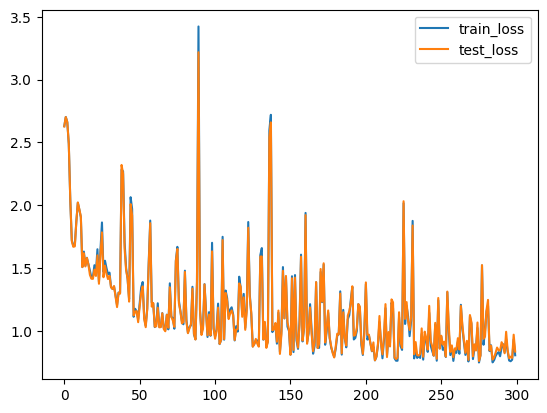

In [9]:
_ = plt.plot(train_losses, label='train_loss')
_ = plt.plot(test_losses, label='test_loss')
_ = plt.legend()

## Visualizing the result

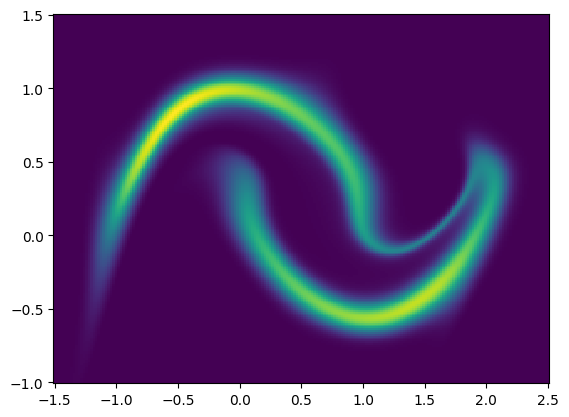

In [10]:
xs = np.linspace(-1.5,2.5,200)
ys = np.linspace(-1,1.5,200)
xs, ys = np.meshgrid(xs, ys)
x = np.stack([xs, ys], axis=2).reshape(-1,2)
with torch.no_grad():
    z, log_det_jacobian = flow.log_det_jacobian(torch.FloatTensor(x))
    px = (flow.log_prob(z) + log_det_jacobian)
    px = px.sum(1).exp()
    px = px.cpu().numpy().reshape(200,200)
    plt.pcolor(xs,ys,px)

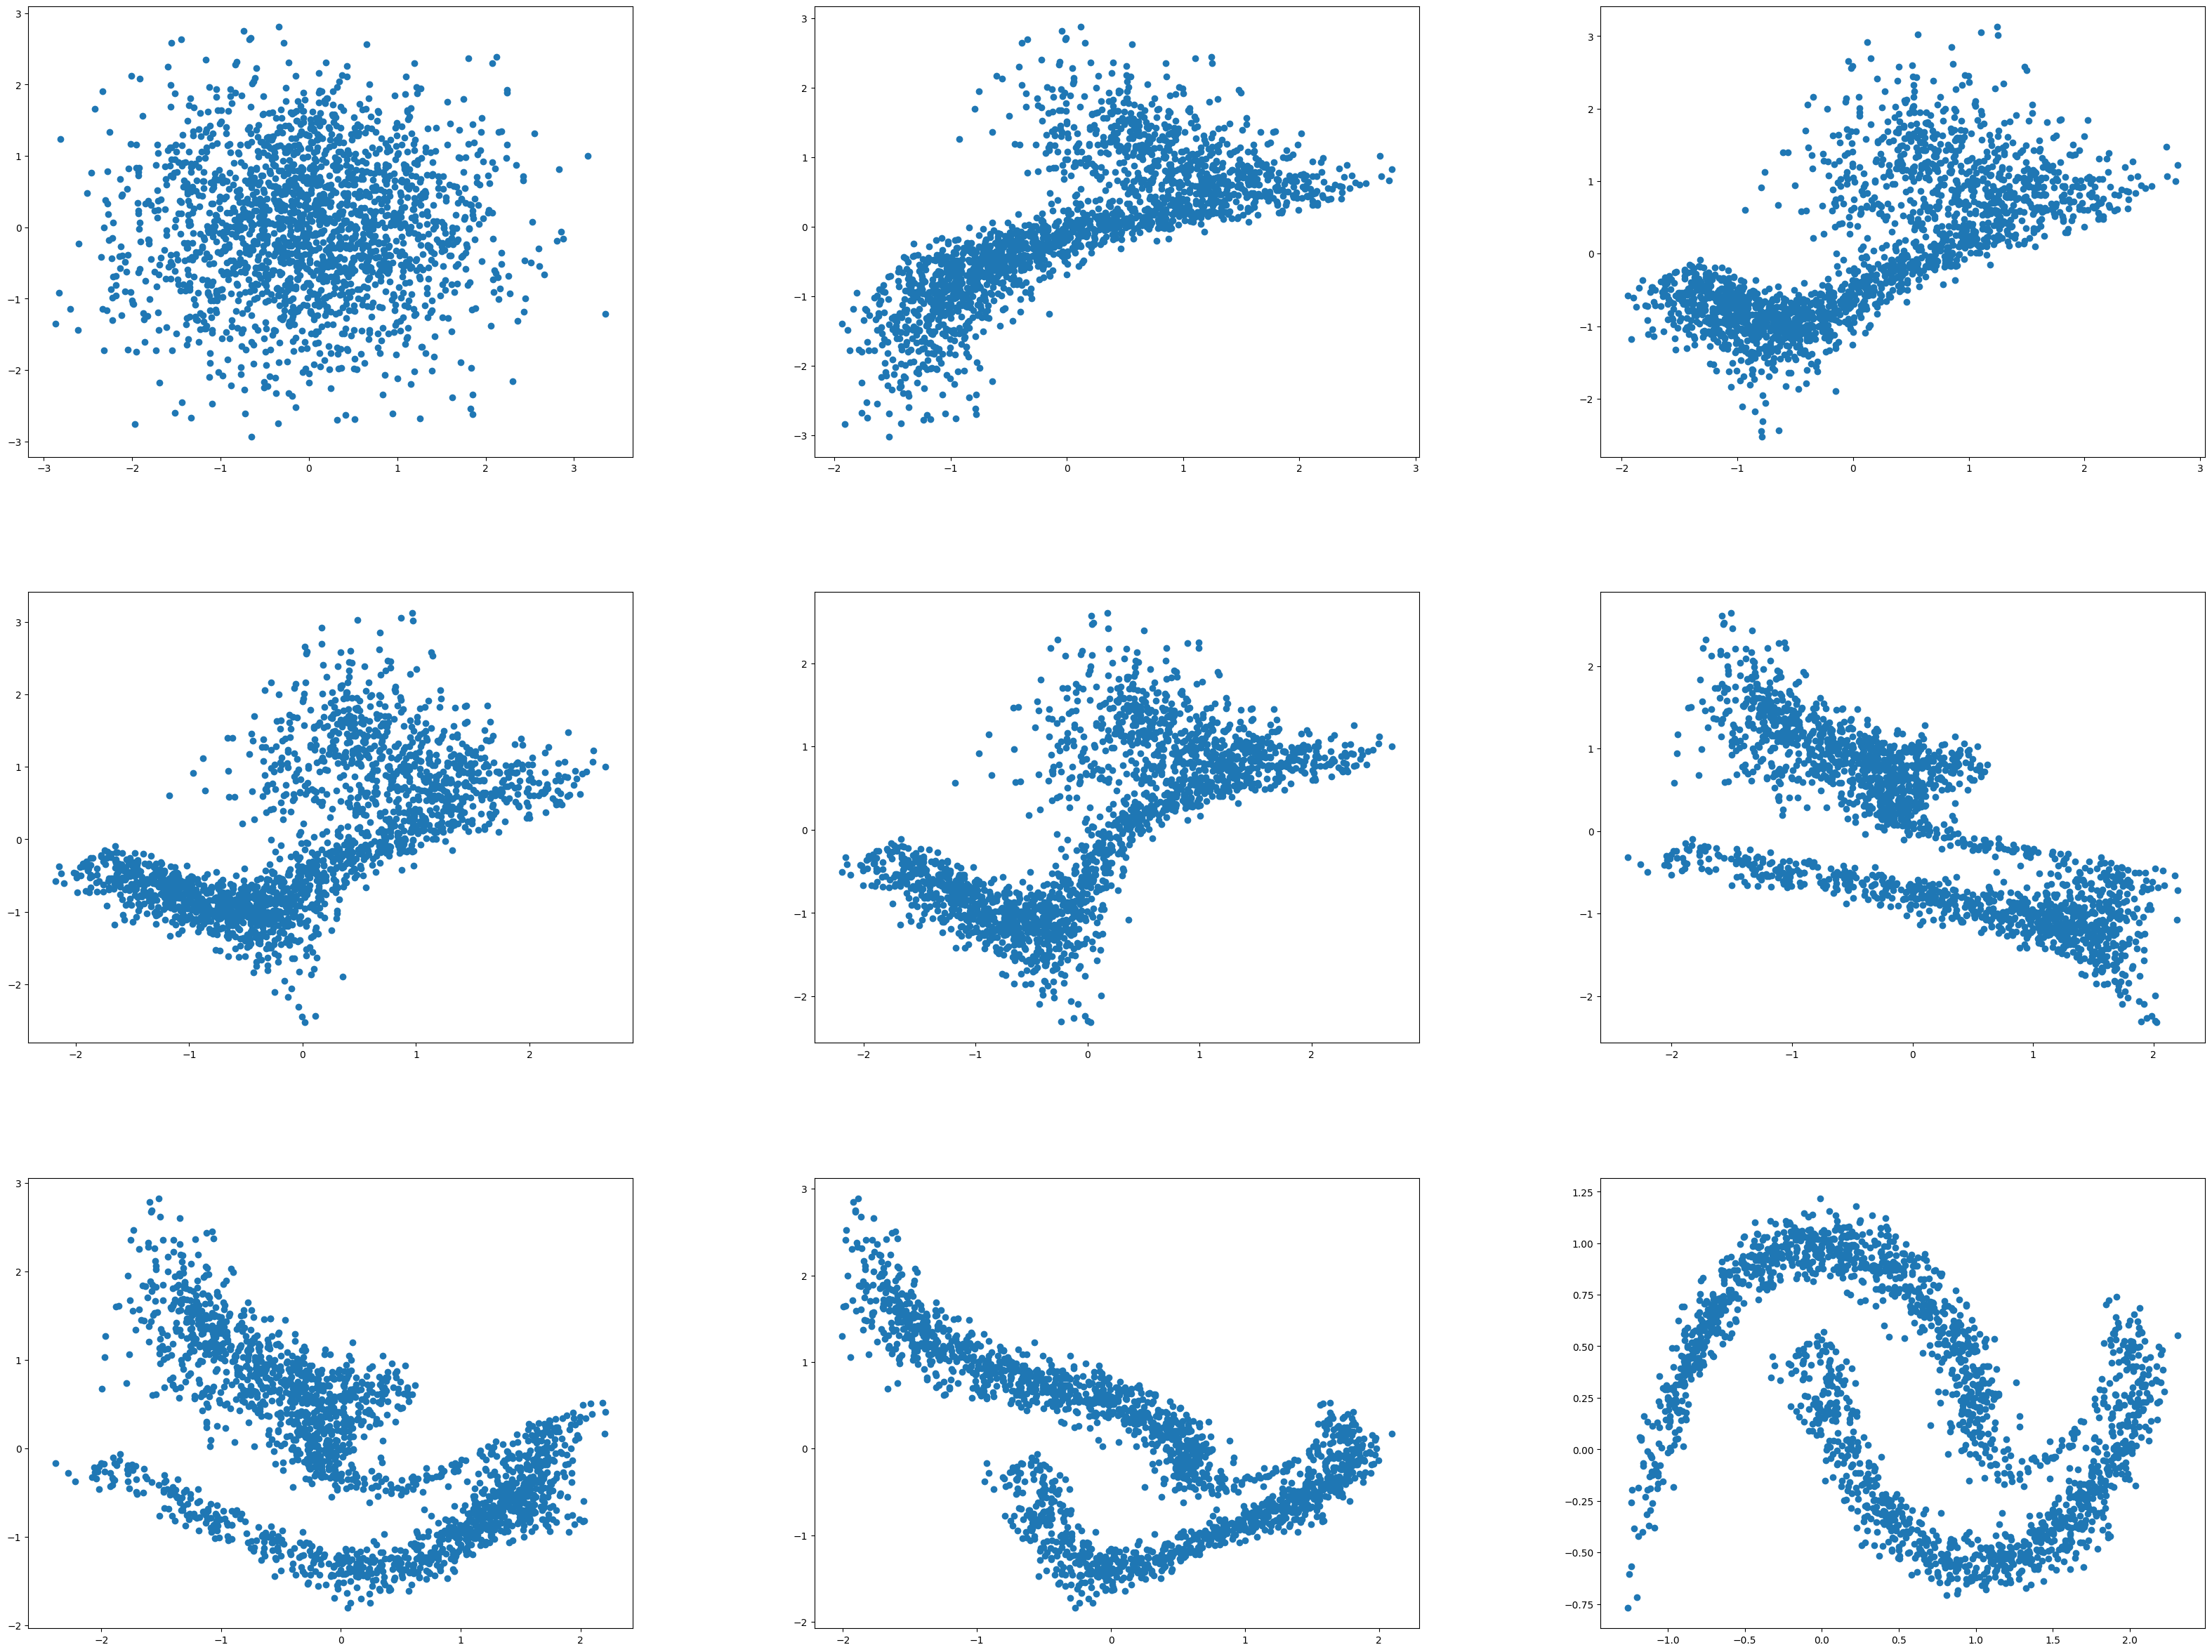

In [11]:
with torch.no_grad():
    f, axes = plt.subplots(3, 3)
    f.set_size_inches((40, 30))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    samples_per_layer = flow.inverse_per_layer(2000)

    for i in range(len(samples_per_layer)):
        z = samples_per_layer[i].cpu().numpy()
        axes[i//3, i%3].scatter(z[:,0], z[:,1])

    plt.show()

In [12]:
label_zero = np.empty((0,2))
label_one = np.empty((0,2))

for n, label in enumerate(test_labels):
    if label == 0:
        label_zero = np.append(label_zero, [test_data[n]], axis=0)
    else:
        label_one = np.append(label_one, [test_data[n]], axis=0)
        
label_zero = torch.Tensor(label_zero)
label_one = torch.Tensor(label_one)

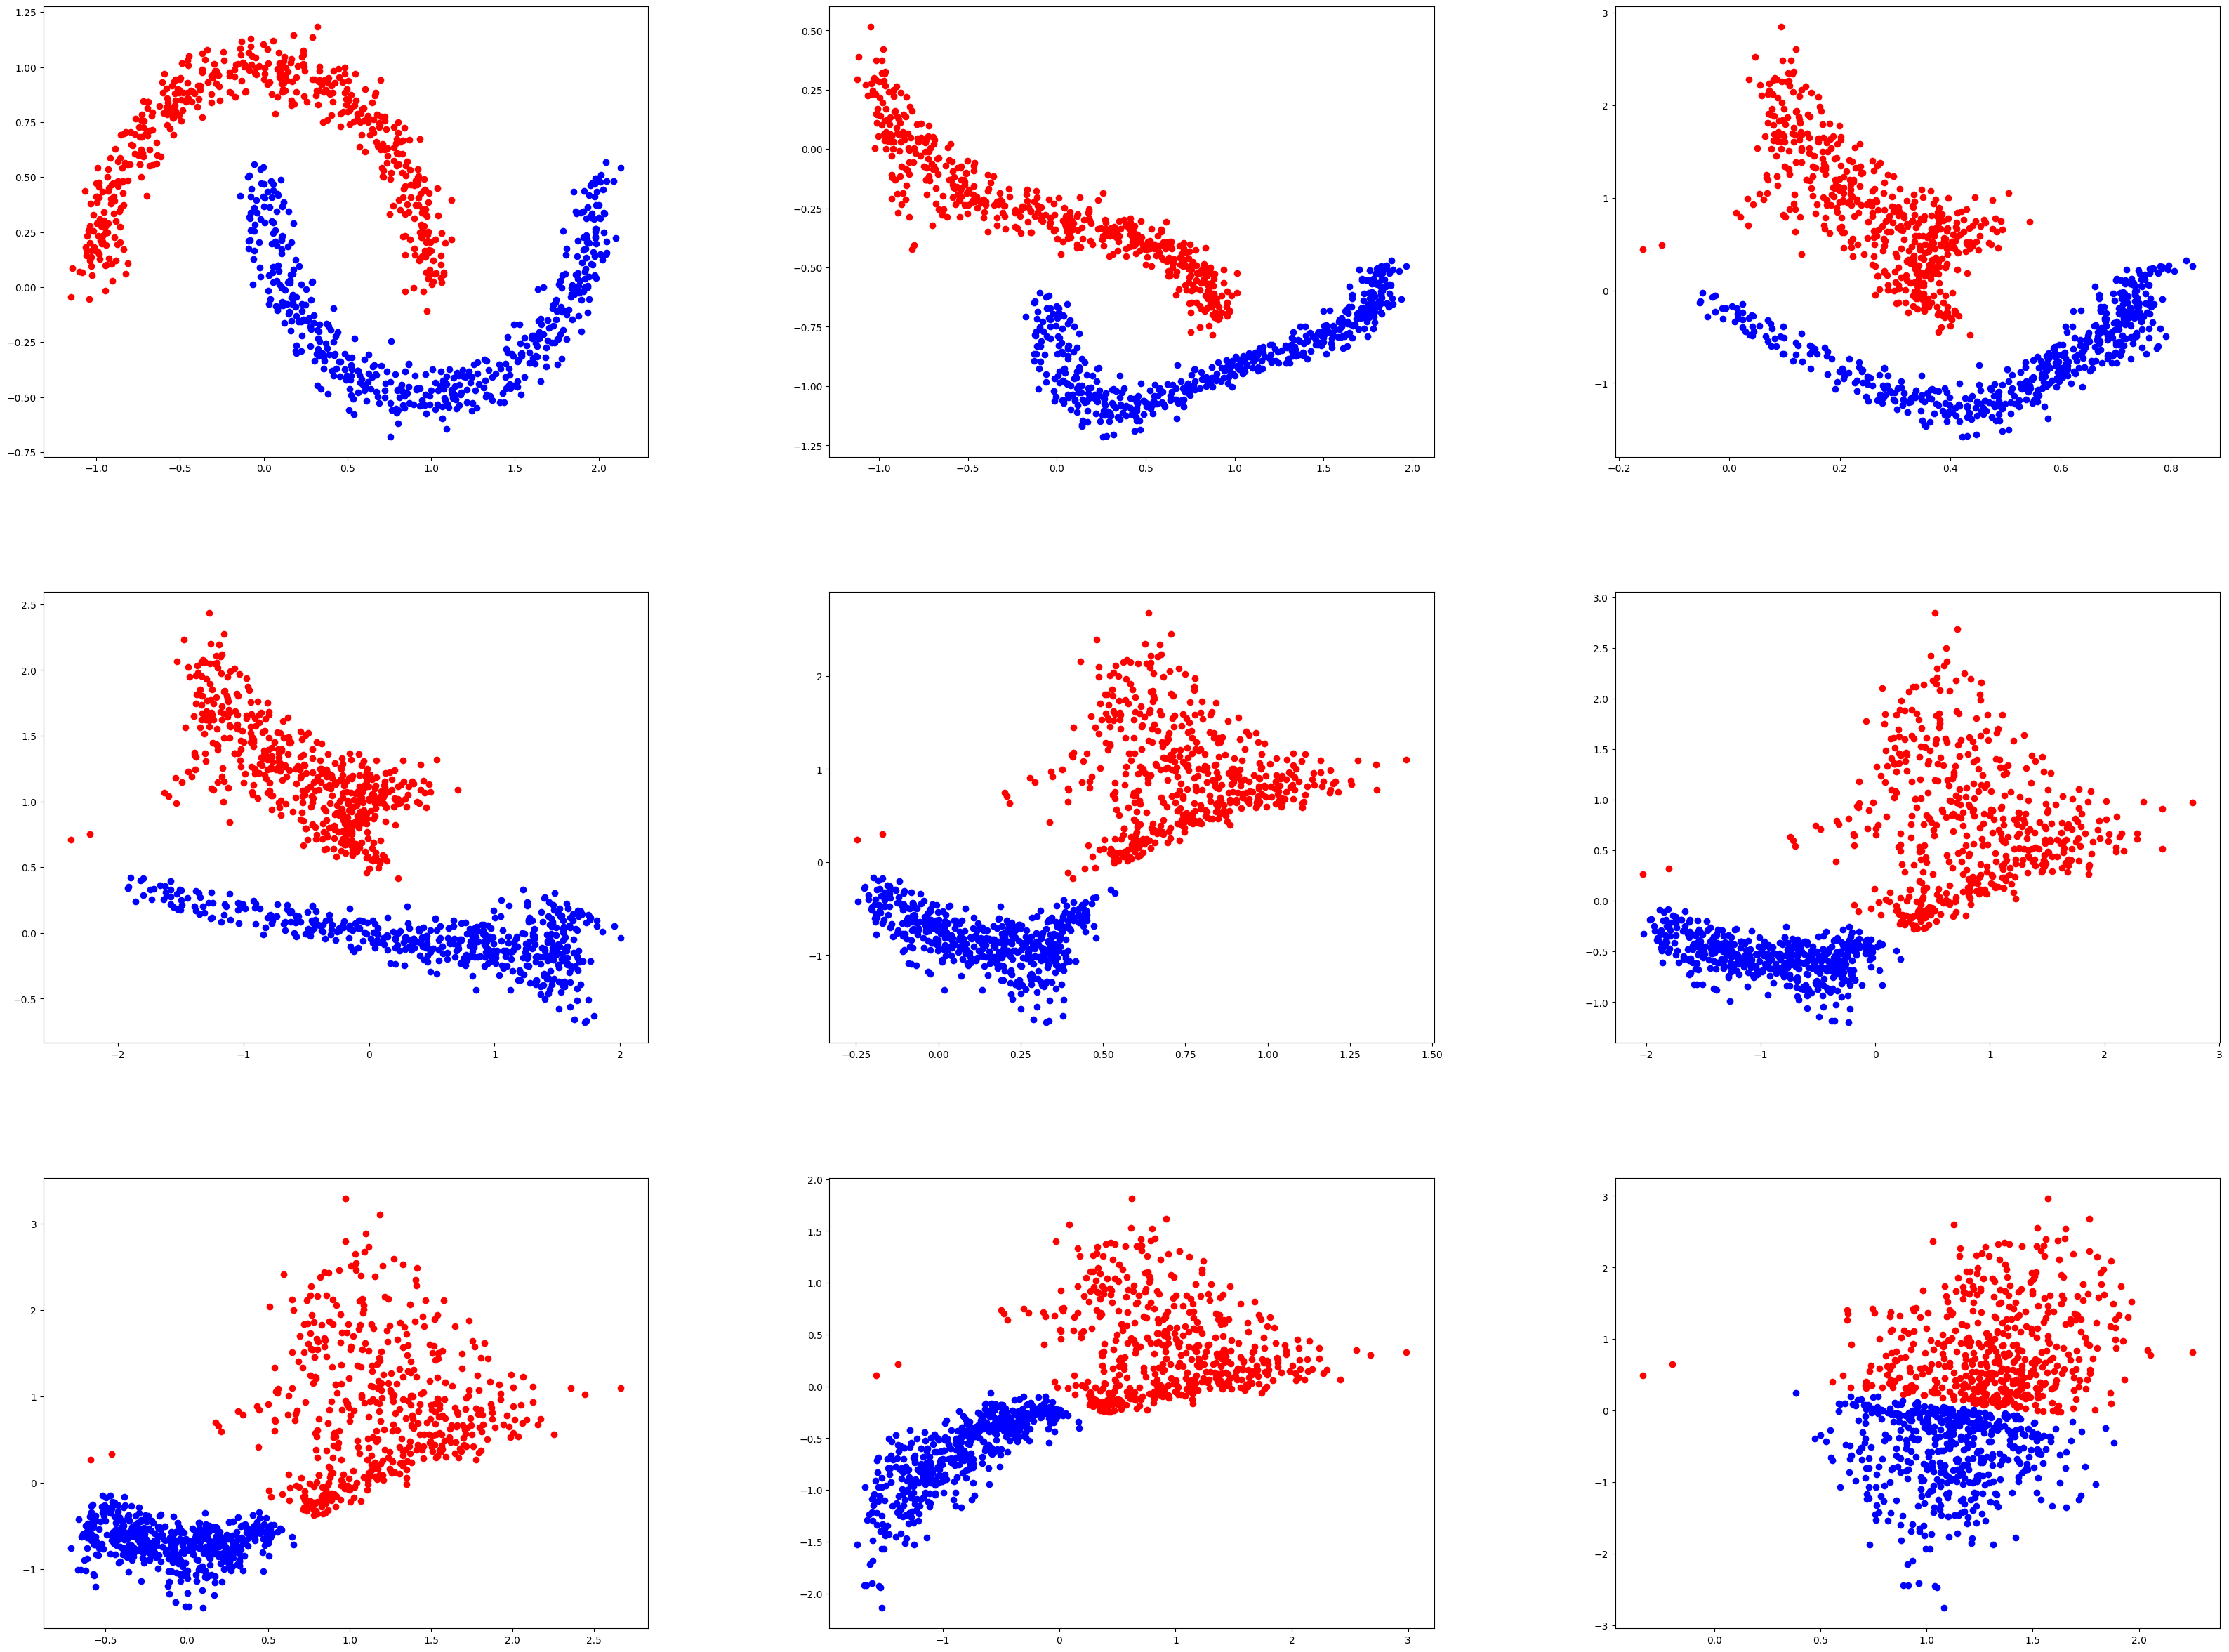

In [13]:
with torch.no_grad():
    f, axes = plt.subplots(3, 3)
    f.set_size_inches((40, 30))
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

    zero_per_layer = flow.forward_per_layer(label_zero)
    one_per_layer = flow.forward_per_layer(label_one)

    for i in range(len(zero_per_layer)):
        zero = zero_per_layer[i].cpu().numpy()
        one = one_per_layer[i].cpu().numpy()
        axes[i//3, i%3].scatter(zero[:,0], zero[:,1], color='red')
        axes[i//3, i%3].scatter(one[:,0], one[:,1], color='blue')

    plt.show()